### ANN Assignment 2

### Name - Aasawaree Deshmukh

### SUID - 986082803

Train and Test with mis-classification cost modification


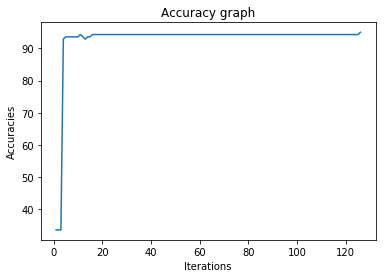

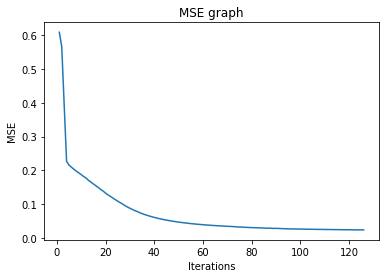

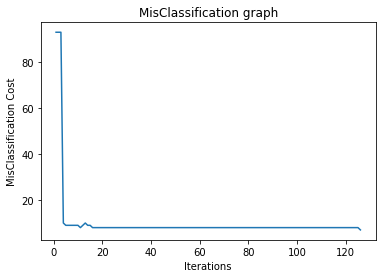

TN, TP, FN, FP => 88 45 2 5
Total Misclassified data  = 7
Accuracy = 95.00
Total iterations -  126
Train and Test without mis-classification cost modification


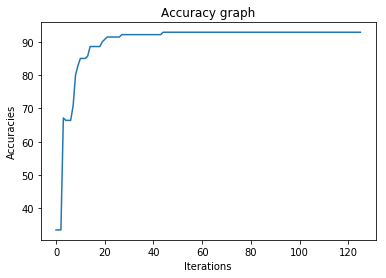

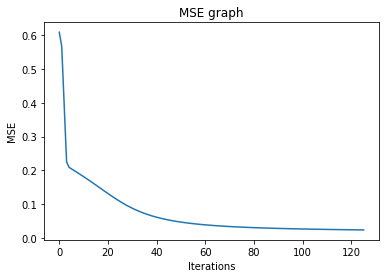

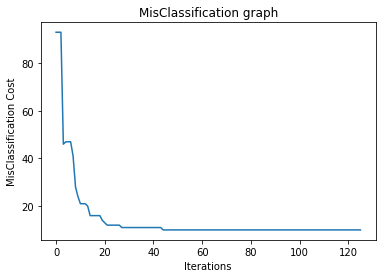

TN, TP, FN, FP => 88 42 5 5
Total Misclassified data  = 10
Accuracy = 92.86


In [2]:
import csv
import math
from copy import deepcopy
from random import random, randrange
import numpy
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def accuracy_metrics(actual, predicted):
    """ Calculate accuracy metric.

    Parameters
    ----------
    actual : list
        list of actual values
    predicted : list
        list of predicted values

    Returns
    -------
    float
        Accuracy
    """
    count = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            count += 1
    return (count / float(len(actual))) * 100


def calculate_confusion_matrix(actual, predicted):
    """Get confusion matrix"""
    tn, fp, fn, tp = confusion_matrix(actual, predicted).ravel()
    print("TN, TP, FN, FP =>", tn, tp, fn, fp)


def cross_validation_batch(data, number_of_splits):
    """ Split dataset into batches.

    Parameters
    ----------
    data : list
        Dataset.
    number_of_splits : int
        number of batches.

    Returns
    -------
    list
        dataset split in batches
    """
    batches = []
    copy_data = list(data)
    batch_size = int(len(data) / number_of_splits)
    for i in range(number_of_splits):
        batch = []
        while len(batch) < batch_size:
            batch.append(copy_data.pop(randrange(len(copy_data))))
        batches.append(batch)
    return batches


def plot_graph(title, xlabel, ylabel, x, y):
    """Plot graph using given parameters.

    Parameters
    ----------
    title : str
        Title for the graph
    xlabel : str
        X axis label.
    ylabel : str
        Y axis label.
    x : list
        x values
    y :list
        y values

    """
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(x, y)
    plt.show()


def load_csv(filename):
    """Load csv data.

    Parameters
    ----------
    filename : str
        Filename.

    Returns
    -------
    list
        CSV data.

    """
    csv_data = []
    with open(filename, 'r') as fp:
        rows = csv.reader(fp)
        for csv_row in rows:
            if not csv_row:
                continue
            cols = []
            for col in csv_row:
                if col == '?' or not col:
                    col = None
                else:
                    col = float(col)
                cols.append(col)
            csv_data.append(cols)
    return csv_data


def str_column_to_int(dataset, column):
    """Convert string column values into int"""
    csv_lookup = {}
    for i, value in enumerate(set([row[column] for row in dataset])):
        csv_lookup[value] = i
    for row in dataset:
        row[column] = csv_lookup[row[column]]
    return csv_lookup


def get_min_max_dataset_values(dataset):
    """
    Parameters
    ----------
    dataset : list
        dataset.

    Returns
    -------
    list
        list of min and max values for each column
    """
    numpy.array(dataset)
    min_and_max_values = [[min(col), max(col)] for col in zip(*dataset)]
    return min_and_max_values


def normalize_data(data, min_and_max_values):
    """ Normalize dataset.

    Parameters
    ----------
    data : list
        Dataset.
    min_and_max_values : list
        min and max values for each column in the dataset.

    """
    for row in data:
        for i in range(len(row) - 1):
            row[i] = (row[i] - min_and_max_values[i][0]) / (min_and_max_values[i][1] - min_and_max_values[i][0])


def initialize_weights(neurons_in_layer1, neurons_in_layer2):
    """ Initialize weights randomly for neurons connected from layer 1 to layer 2.

    Parameters
    ----------
    neurons_in_layer1 : int
        Number of neurons in first layer.
    neurons_in_layer2 : int
        Number of neurons in second layer.

    Returns
    -------
    list
        Randomly generated weights.
        Example : [{'weights':[w1,w2...]}, ...]
    """
    weighted_neurons_with_bias = []
    total_number_of_weights_and_bias = neurons_in_layer1 + 1
    for i in range(neurons_in_layer2):
        random_weights = []
        for j in range(total_number_of_weights_and_bias):
            random_weights.append(random())
        weighted_neurons_with_bias.append({'weights': random_weights})
    return weighted_neurons_with_bias


def replace_missing_data_with_mean(dataset):
    """ Fill missing data with the mean of that column

    Parameters
    ----------
    dataset : list
        Dataset

    Returns
    -------
    list
        Dataset
    """
    ndataset = numpy.array(dataset, dtype=numpy.float)
    column_mean = numpy.nanmean(ndataset, axis=0)
    indices = numpy.where(numpy.isnan(ndataset))
    ndataset[indices] = numpy.take(column_mean, indices[1])
    return ndataset.tolist()


def create_neural_network(input_attributes, output_classes, hidden_layer_neurons):
    """ Create/Initialize a single hidden layered neural network based on input parameters.

    Parameters
    ----------
    input_attributes : int
        The number of input attributes or parameters for the neural network.
    output_classes : int
        The number of output classes for the neural network.
    hidden_layer_neurons : int
        The number of hidden neurons withint he hidden layer.

    Returns
    -------
    dict
        Neural network.
        Example :
        {
            'hidden_layer': [{'weights':[w1,w2...]},...],
            'output_layer': [{'weights':[w3,w4...]},...],
        }

    """
    neural_network = {'hidden_layer': initialize_weights(input_attributes, hidden_layer_neurons),
                      'output_layer': initialize_weights(hidden_layer_neurons, output_classes)}
    return neural_network


def neuron_activation_function(input_vector, weight_vector):
    """ Calculate weighted sum along with bias for each neuron's activation function.

    Parameters
    ----------
    input_vector : list
        Input vector values.
    weight_vector : list
        Weight vector values.

    Returns
    -------
    float
        Net weighted sum along with bias for each neuron.

    """
    net_weighted_sum = 0
    number_of_activation_function = len(weight_vector) - 1
    for i in range(number_of_activation_function):
        net_weighted_sum += float(input_vector[i]) * weight_vector[i]
    return net_weighted_sum + weight_vector[-1]


def logistic_function(net_neuron_activation_value):
    """ Calculate the logistic function value i.e. sigmoid function value.

    Parameters
    ----------
    net_neuron_activation_value : float
        Weighted sum along with bias for a neuron i.e. neuron activation value.

    Returns
    -------
    float
        Value of sigmoid function.
    """
    sigmoid = 1 / (1 + math.exp(-net_neuron_activation_value))
    return sigmoid


def derivative_of_logistic_function(logistic_function_value):
    """ Calculate derivative of sigmoid function.

    Parameters
    ----------
    logistic_function_value : float
        Value of sigmoid function.

    Returns
    -------
    float
        Derivative of sigmoid function.
    """
    derivative_sigmoid = logistic_function_value * (1 - logistic_function_value)
    return derivative_sigmoid


def forward_propagation(input_vector, neural_network_layer):
    """ Calculate the output vector for next layer in neural network based
        on net neuron activation values of previous layer in neural network.

    Paramters
    ---------
    input_vector : list
        List of input vector values.
    neural_network_layer : dict
        Layer attributes within the neural network.

    Returns
    -------
    list
        List of input vector for the next layer within neural network.
    """
    next_input_vector = []
    for vector in neural_network_layer:
        net_neuron_activation_value = neuron_activation_function(input_vector, vector['weights'])
        vector['activation_output'] = logistic_function(net_neuron_activation_value)
        next_input_vector.append(vector['activation_output'])
    return next_input_vector


def feed_forward_propagation(neural_network, input_vector):
    """Feed forward propagation for single hidden layered neural network.

    Parameters
    ----------
    neural_network : dict
        Neural Network.
    input_vector : list
        Input vector values

    Returns
    -------
    list
        Output vector values.

    """
    next_input_vector = forward_propagation(input_vector, neural_network['hidden_layer'])
    output_vector = forward_propagation(next_input_vector, neural_network['output_layer'])
    return output_vector


def back_propagation(neural_network, expected_output):
    """ Back propagation algorithm for a single hidden layered neural network.
        Update neural network with calculated delta values.

    Parameters
    ----------
    neural_network : dict
        Neural Network.
    expected_output : list
        Expected output for a particular input.

    """
    errors = []
    for i in range(len(neural_network['output_layer'])):
        neuron = neural_network['output_layer'][i]
        errors.append(expected_output[i] - neuron['activation_output'])

    for i in range(len(neural_network['output_layer'])):
        neuron = neural_network['output_layer'][i]
        neuron['delta'] = errors[i] * derivative_of_logistic_function(neuron['activation_output'])

    errors = []
    for i in range(len(neural_network['hidden_layer'])):
        error = 0.0
        for neuron in neural_network['output_layer']:
            error += (neuron['weights'][i] * neuron['delta'])
        errors.append(error)
    for i in range(len(neural_network['hidden_layer'])):
        neuron = neural_network['hidden_layer'][i]
        neuron['delta'] = errors[i] * derivative_of_logistic_function(neuron['activation_output'])


def redefine_weights(neural_network, input_vector, learning_rate, misclassification):
    """ Update weights after back_propagation.

    Parameters
    ----------
    neural_network : dict
        Neural Network.
    input_vector : list
        Input vector values
    learning_rate : float
        learning rate.
    misclassification: float
        misclassification

    """
    redefined_learning_rate = learning_rate + (misclassification * 0.1) if misclassification >= 1 else learning_rate
    input_values = input_vector[:-1]
    for neuron in neural_network['hidden_layer']:
        for i in range(len(input_values)):
            neuron['weights'][i] += redefined_learning_rate * neuron['delta'] * float(input_values[i])
        neuron['weights'][-1] += redefined_learning_rate * neuron['delta']

    input_values = [neuron['activation_output'] for neuron in neural_network['hidden_layer']]

    for neuron in neural_network['output_layer']:
        for i in range(len(input_values)):
            neuron['weights'][i] += redefined_learning_rate * neuron['delta'] * input_values[i]
        neuron['weights'][-1] += redefined_learning_rate * neuron['delta']


def train_neural_network_with_modification(neural_network, train_dataset, test_dataset, learning_rate, fn_threshold,
                                           cost):
    """ Train neural network.

    Parameters
    ----------
    neural_network : dict
        Neural Network.
    train_dataset : list
        train dataset
    test_dataset : list
        test dataset
    learning_rate : float
        learning rate
    fn_threshold : int
        false negative threshold
    cost : matrix
        cost matrix

    Returns
    -------
    x_value, mse, accuracies, misclassified_over_iterations : (list, list, list, list)

    """
    mse = []
    fn = len(train_dataset)
    x_count = 0
    x_value = []
    accuracies = []
    misclassified_over_iterations = []

    while fn_threshold != fn:
        x_count += 1
        x_value.append(x_count)
        error = 0
        for dataset_entry in train_dataset:
            feed_forward_output = feed_forward_propagation(neural_network, dataset_entry)
            if feed_forward_output[0] >= 0.50:
                matrix_index = 1
            else:
                matrix_index = 0
            expected = [dataset_entry[-1]]
            error += (expected[0] - feed_forward_output[0]) ** 2
            back_propagation(neural_network, expected)
            redefine_weights(neural_network, dataset_entry, learning_rate, cost[matrix_index, dataset_entry[-1]])
        mse.append(error / len(train_dataset))

        predictions = []
        misclassified = 0
        for dataset_entry in test_dataset:
            prediction = test_neural_network(neural_network, dataset_entry)
            if prediction != dataset_entry[-1]:
                misclassified += 1
            predictions.append(prediction)

        misclassified_over_iterations.append(misclassified)
        actual = [row[-1] for row in test_dataset]
        accuracy = accuracy_metrics(actual, predictions)
        accuracies.append(accuracy)
        tn, fp, fn, tp = confusion_matrix(actual, predictions).ravel()

    return x_value, mse, accuracies, misclassified_over_iterations


def train_neural_network_without_modification(neural_network, train_dataset, test_dataset, learning_rate, iterations,
                                              cost):
    """ Train neural network.

    Parameters
    ----------
    neural_network : dict
        Neural Network.
    train_dataset : list
        train dataset
    test_dataset : list
        test dataset
    learning_rate : float
        learning rate
    iterations : int
        number of iterations
    cost : matrix
        cost matrix

    Returns
    -------
    x_value, mse, accuracies, misclassified_over_iterations : (list, list, list, list)

    """
    mse = []
    x_value = []
    accuracies = []
    misclassified_over_iterations = []

    for iteration in range(iterations):
        x_value.append(iteration)
        error = 0
        for dataset_entry in train_dataset:
            feed_forward_output = feed_forward_propagation(neural_network, dataset_entry)
            if feed_forward_output[0] >= 0.50:
                matrix_index = 1
            else:
                matrix_index = 0
            misclassification = cost[matrix_index, dataset_entry[-1]]
            expected = [dataset_entry[-1]]
            error += (expected[0] - feed_forward_output[0]) ** 2
            back_propagation(neural_network, expected)
            redefine_weights(neural_network, dataset_entry, learning_rate, misclassification)
        mse.append(error / len(train_dataset))

        predictions = []
        misclassified = 0
        for dataset_entry in test_dataset:
            prediction = test_neural_network(neural_network, dataset_entry)
            if prediction != dataset_entry[-1]:
                misclassified += 1
            predictions.append(prediction)

        misclassified_over_iterations.append(misclassified)
        actual = [row[-1] for row in test_dataset]
        accuracy = accuracy_metrics(actual, predictions)
        accuracies.append(accuracy)

    return x_value, mse, accuracies, misclassified_over_iterations


def test_neural_network(neural_network, input_vector):
    """ Test neural network.

    Parameters
    ----------
    neural_network : dict
        Neural Network.

    """
    result = feed_forward_propagation(neural_network, input_vector)
    if result[0] >= 0.50:
        return 1
    else:
        return 0


def train_and_test_with_modification(neural_network, train_dataset, test_dataset, learning_rate, fn_threshold, matrix):
    """Train and test neural network with different mis-classification cost.

    Parameters
    ----------
    neural_network : dict
        Neural Network.
    train_dataset : list
        train dataset
    test_dataset : list
        test dataset
    learning_rate : float
        learning rate
    fn_threshold : int
        false negative threshold value
    matrix : list
        cost matrix

    Returns
    -------
    int
        number of iterations neural network achieved false negative threshold
    """
    x_values, mse, accuracies, mc = train_neural_network_with_modification(neural_network, train_dataset,
                                                                           test_dataset, learning_rate,
                                                                           fn_threshold, matrix)

    plot_graph('Accuracy graph', 'Iterations', 'Accuracies', x_values, accuracies)

    plot_graph('MSE graph', 'Iterations', 'MSE', x_values, mse)

    plot_graph('MisClassification graph', 'Iterations', 'MisClassification Cost', x_values, mc)

    misclassified = 0
    predictions = []
    for entry in test_dataset:
        prediction = test_neural_network(neural_network, entry)
        if prediction != entry[-1]:
            misclassified += 1
        predictions.append(prediction)

    actual = [row[-1] for row in test_dataset]
    accuracy = accuracy_metrics(actual, predictions)
    accuracies.append(accuracy)
    calculate_confusion_matrix(actual, predictions)

    print("Total Misclassified data  = %d" % misclassified)
    print("Accuracy = %.2f" % accuracy)
    return len(x_values)


def train_and_test_without_modification(neural_network, train_dataset, test_dataset, learning_rate, iterations, matrix):
    """Train and test neural network with different mis-classification cost.

    Parameters
    ----------
    neural_network : dict
        Neural Network.
    train_dataset : list
        train dataset
    test_dataset : list
        test dataset
    learning_rate : float
        learning rate
    iterations : int
        number of iterations
    matrix : list
        cost matrix

    """
    x_values, mse, accuracies, mc = train_neural_network_without_modification(neural_network, train_dataset,
                                                                              test_dataset, learning_rate,
                                                                              iterations, matrix)

    plot_graph('Accuracy graph', 'Iterations', 'Accuracies', x_values, accuracies)

    plot_graph('MSE graph', 'Iterations', 'MSE', x_values, mse)

    plot_graph('MisClassification graph', 'Iterations', 'MisClassification Cost', x_values, mc)

    misclassified = 0
    predictions = []
    for entry in test_dataset:
        prediction = test_neural_network(neural_network, entry)
        if prediction != entry[-1]:
            misclassified += 1
        predictions.append(prediction)

    actual = [row[-1] for row in test_dataset]
    accuracy = accuracy_metrics(actual, predictions)
    accuracies.append(accuracy)
    calculate_confusion_matrix(actual, predictions)

    print("Total Misclassified data  = %d" % misclassified)
    print("Accuracy = %.2f" % accuracy)


def run_code(train, test):
    """ Train, Test and evaluate neural network on a given dataset. """
    learning_rate = 0.0086
    
    # FN Threshold Value     
    fn_threshold = 2

    # To make use of the redefined learning rate
    cost_matrix = numpy.matrix([[0, 1.2], [0.6, 0]])

    # To make use of the predefined learning rate
    no_cost_matrix = numpy.matrix([[0, 0], [0, 0]])

    # Load and normalize train/test dataset
    train_data = load_csv(train)
    test_data = load_csv(test)
    train_dataset = replace_missing_data_with_mean(train_data)
    test_dataset = replace_missing_data_with_mean(test_data)
    str_column_to_int(train_dataset, len(train_dataset[0]) - 1)
    str_column_to_int(test_dataset, len(test_dataset[0]) - 1)
    min_and_max_values_train = get_min_max_dataset_values(train_dataset)
    min_and_max_values_test = get_min_max_dataset_values(test_dataset)
    normalize_data(train_dataset, min_and_max_values_train)
    normalize_data(test_dataset, min_and_max_values_test)

    number_of_inputs = len(train_dataset[0]) - 1
    number_of_outputs = 1
    number_of_hiddens = 9

    neural_network = create_neural_network(number_of_inputs, number_of_outputs, number_of_hiddens)
    neural_network2 = deepcopy(neural_network)

    # Train with cost matrix
    print("Train and Test with mis-classification cost modification")
    iterations = train_and_test_with_modification(neural_network, train_dataset, test_dataset, learning_rate,
                                                  fn_threshold, cost_matrix)
    print("Total iterations -  %d" % iterations)

    # Train without cost matrix
    print("Train and Test without mis-classification cost modification")
    train_and_test_without_modification(neural_network2, train_dataset, test_dataset, learning_rate,
                                        iterations, no_cost_matrix)


# Execute code
run_code("x_train.csv", "x_test.csv")
